# ANN Model for Urban Sound Classification

## Installing Required Libraries

In [63]:
!pip install librosa

In [64]:
!pip install tensorflow

In [65]:
!pip install matplotlib

In [66]:
!pip install pandas

In [67]:
!pip install tqdm

In [68]:
!pip install imbalanced-learn

In [69]:
!pip install keras-tuner

## Importing Required Dependencies

In [156]:
# Standard Libraries
import os
from collections import Counter

# Data Handling Libraries
import numpy as np
import pandas as pd
import joblib

# Audio Processing Libraries
import librosa

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

# Deep Learning Libraries (Tensorflow/Keras)
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Dataset Preparation

### Load the Dataset

In [136]:
metadata = pd.read_csv('../Data/UrbanSound8K.csv')
metadata

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


### Feature Extraction

In [137]:
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, sr=None)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)
    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}")
        return None
    return mfccs_scaled

In [138]:
audio_dataset_path = r'F:\\SE\\SLIIT\\Y04S01\\Deep Learning\\Assignments\\DL\\Data'

In [139]:
features = []
labels = []

In [13]:
for index_num,row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=extract_features(file_name)
    features.append(data)
    labels.append(final_class_labels)

 33%|█████████████████████████▍                                                    | 2849/8732 [02:41<03:58, 24.71it/s]F:\SE\miniconda3\envs\audio_classification\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
100%|██████████████████████████████████████████████████████████████████████████████| 8732/8732 [07:34<00:00, 19.22it/s]


In [17]:
df_features = pd.DataFrame(features)
df_labels = pd.DataFrame(labels, columns=['label'])

df_extracted_features = pd.concat([df_features, df_labels], axis=1)

df_extracted_features.to_csv('./audio_features.csv', index=False)

###  Load and Prepare Data

In [140]:
df_audio_features = pd.read_csv('./audio_features.csv')
df_audio_features

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-275.91843,119.49280,-98.211780,-66.515140,-42.606045,0.505065,-28.330938,-5.746867,9.992785,4.795412,...,-3.562049,1.710327,1.032513,-4.748238,-4.013623,0.116839,6.310030,1.492271,1.462320,dog_bark
1,-500.90840,185.10641,-86.532820,49.858850,9.230822,22.548956,-3.567175,12.220054,7.720082,-6.460392,...,-1.856354,0.372866,-3.269187,-1.969773,-1.598099,0.562077,0.463689,-0.359663,0.909601,children_playing
2,-531.19530,186.93994,-70.349160,40.429245,9.121048,18.398588,6.283283,15.504061,9.613501,-7.113610,...,-0.291961,0.287639,-3.358315,1.434627,-0.975246,2.386079,-0.347919,-3.844178,-0.731597,children_playing
3,-476.78442,160.33328,-62.952843,50.751170,-0.174330,32.791600,-17.469800,24.755478,-3.847784,-1.761176,...,-3.374202,-1.012279,-1.025993,-3.666372,-0.071535,-5.693183,1.876606,-1.428173,3.510686,children_playing
4,-521.24470,185.39265,-81.950470,46.473550,11.872088,23.491444,4.261836,13.637699,6.093238,-2.813453,...,-0.331206,2.441440,0.449653,1.609697,-2.679410,-0.054824,-2.050368,-1.784189,2.869685,children_playing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,-466.63190,193.29425,-63.960163,30.475616,-9.339019,23.975900,-14.627114,27.502554,3.764655,4.351699,...,-5.908267,-0.086640,8.064040,4.842944,-1.370681,-8.400169,1.039638,2.128600,4.718456,car_horn
8728,-396.77737,134.76804,-64.882770,42.310800,-1.868765,0.876937,-36.872646,42.781456,-9.984668,-5.920937,...,1.580030,-4.441753,3.187478,-3.398616,1.737199,3.312875,2.611360,0.158990,0.844661,car_horn
8729,-362.70322,165.08179,-60.780693,30.996470,-9.655406,23.180807,-18.668148,27.321250,-7.465636,7.173614,...,2.579410,-2.790286,2.743992,-4.914998,-4.034190,-5.768603,-1.840645,2.607495,3.903050,car_horn
8730,-404.62810,178.50473,-63.615627,25.944529,-10.428956,12.489921,-24.788843,35.468410,-3.097389,0.915603,...,-0.693243,-2.208296,4.955165,-0.435411,-1.857112,-7.561952,-0.168980,3.911847,4.805305,car_horn


In [141]:
x = df_audio_features.drop(columns=['label'])
y = df_audio_features['label'].values

In [142]:
x.shape

(8732, 40)

In [143]:
x

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-275.91843,119.49280,-98.211780,-66.515140,-42.606045,0.505065,-28.330938,-5.746867,9.992785,4.795412,...,-1.271639,-3.562049,1.710327,1.032513,-4.748238,-4.013623,0.116839,6.310030,1.492271,1.462320
1,-500.90840,185.10641,-86.532820,49.858850,9.230822,22.548956,-3.567175,12.220054,7.720082,-6.460392,...,-1.534701,-1.856354,0.372866,-3.269187,-1.969773,-1.598099,0.562077,0.463689,-0.359663,0.909601
2,-531.19530,186.93994,-70.349160,40.429245,9.121048,18.398588,6.283283,15.504061,9.613501,-7.113610,...,-0.745467,-0.291961,0.287639,-3.358315,1.434627,-0.975246,2.386079,-0.347919,-3.844178,-0.731597
3,-476.78442,160.33328,-62.952843,50.751170,-0.174330,32.791600,-17.469800,24.755478,-3.847784,-1.761176,...,1.358762,-3.374202,-1.012279,-1.025993,-3.666372,-0.071535,-5.693183,1.876606,-1.428173,3.510686
4,-521.24470,185.39265,-81.950470,46.473550,11.872088,23.491444,4.261836,13.637699,6.093238,-2.813453,...,-1.044175,-0.331206,2.441440,0.449653,1.609697,-2.679410,-0.054824,-2.050368,-1.784189,2.869685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,-466.63190,193.29425,-63.960163,30.475616,-9.339019,23.975900,-14.627114,27.502554,3.764655,4.351699,...,-0.528295,-5.908267,-0.086640,8.064040,4.842944,-1.370681,-8.400169,1.039638,2.128600,4.718456
8728,-396.77737,134.76804,-64.882770,42.310800,-1.868765,0.876937,-36.872646,42.781456,-9.984668,-5.920937,...,-6.215810,1.580030,-4.441753,3.187478,-3.398616,1.737199,3.312875,2.611360,0.158990,0.844661
8729,-362.70322,165.08179,-60.780693,30.996470,-9.655406,23.180807,-18.668148,27.321250,-7.465636,7.173614,...,-5.558697,2.579410,-2.790286,2.743992,-4.914998,-4.034190,-5.768603,-1.840645,2.607495,3.903050
8730,-404.62810,178.50473,-63.615627,25.944529,-10.428956,12.489921,-24.788843,35.468410,-3.097389,0.915603,...,-0.364295,-0.693243,-2.208296,4.955165,-0.435411,-1.857112,-7.561952,-0.168980,3.911847,4.805305


In [144]:
y.shape

(8732,)

In [145]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype=object)

In [146]:
y = np.array(pd.get_dummies(y, dtype=int))
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

### Data Resampling

In [147]:
smote = SMOTE(random_state=0)
x_resampled, y_resampled = smote.fit_resample(x, y)

y_resampled_labels = np.argmax(y_resampled, axis=1)

counter = Counter(y_resampled_labels)

print("Class distribution after resampling:\n", counter)

Class distribution after resampling:
 Counter({3: 1000, 2: 1000, 1: 1000, 0: 1000, 9: 1000, 6: 1000, 8: 1000, 5: 1000, 7: 1000, 4: 1000})


## Train-Test Split and Scaling

In [148]:
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=0)

In [149]:
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

joblib.dump(scaler, 'standard_scaler.pkl')

['standard_scaler.pkl']

## Hyperparameter Tuning

### Function build_model

In [150]:
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(
        units=hp.Int('units_1', min_value=128, max_value=512, step=64, default=256),
        input_shape=(40,)
    ))
    model.add(Activation(hp.Choice('activation_1', values=['relu', 'tanh'], default='relu')))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.7, step=0.1, default=0.5)))
    
    model.add(Dense(
        units=hp.Int('units_2', min_value=128, max_value=512, step=64, default=256)
    ))
    model.add(Activation(hp.Choice('activation_2', values=['relu', 'tanh'], default='relu')))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.7, step=0.1, default=0.5)))
    
    model.add(Dense(y_resampled.shape[1]))
    model.add(Activation('softmax'))
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### Function for Hyperparameter Tuning

In [151]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [152]:
possible_epoch_values = [50, 100]

In [153]:
for epoch_count in possible_epoch_values:
    tuner = kt.GridSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=2,
        directory='tuner_dir_hp',
        project_name=f'ANN_Audio_Classification_{epoch_count}'
    )

    history = tuner.search(x_train, y_train,
                 epochs=epoch_count,
                 validation_split=0.2,
                 callbacks=[early_stopping])

Reloading Tuner from tuner_dir_hp\ANN_Audio_Classification_50\tuner0.json
Reloading Tuner from tuner_dir_hp\ANN_Audio_Classification_100\tuner0.json


In [166]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Fitting Hyperparameters:")
for hp_name, hp_value in best_fitting_hyperparameters.values.items():
    print(f"{hp_name}: {hp_value}")

Best Fitting Hyperparameters:
units_1: 256
activation_1: relu
dropout_1: 0.5
units_2: 256
activation_2: relu
dropout_2: 0.5


## Model Building and Training

### Building the Model

In [157]:
model = Sequential()
model.add(Input(shape=(40,)))

model.add(Dense(units=best_hp.get('units_1')))
model.add(Activation(best_hp.get('activation_1')))
model.add(Dropout(best_hp.get('dropout_1')))

model.add(Dense(units=best_hp.get('units_2')))
model.add(Activation(best_hp.get('activation_2')))
model.add(Dropout(best_hp.get('dropout_2')))

model.add(Dense(y_resampled.shape[1]))
model.add(Activation('softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Training the Model

In [158]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
restore_best_weights=True)
history = model.fit(
    x_train, y_train,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2921 - loss: 2.0126 - val_accuracy: 0.6175 - val_loss: 1.2038
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5567 - loss: 1.3133 - val_accuracy: 0.6994 - val_loss: 0.9365
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6287 - loss: 1.0964 - val_accuracy: 0.7387 - val_loss: 0.7977
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6846 - loss: 0.9657 - val_accuracy: 0.7694 - val_loss: 0.7153
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7167 - loss: 0.8590 - val_accuracy: 0.7850 - val_loss: 0.6543
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7336 - loss: 0.8108 - val_accuracy: 0.7919 - val_loss: 0.6248
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7518 - loss: 0.7479 - val_accuracy: 0.8169 - val_loss: 0.5655
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7725 - loss: 0.7029 - val_accuracy: 0.

In [169]:
model.save('ann_audio_model.keras')

In [170]:
history_dictionary = history.history
joblib.dump(history_dictionary, 'ann_model_history.pkl')

['ann_model_history.pkl']

## Model Evaluation

### Model Loss and Accuracy

In [189]:
load_model = load_model('ann_audio_model.keras')

In [190]:
test_metrics = load_model.evaluate(x_test, y_test, verbose=0)

print(f"Loss: {test_metrics[0]}")
print(f"Test Accuracy: {test_metrics[1]}")

Loss: 0.2455528974533081
Test Accuracy: 0.9244999885559082


### Plotting

#### Training History

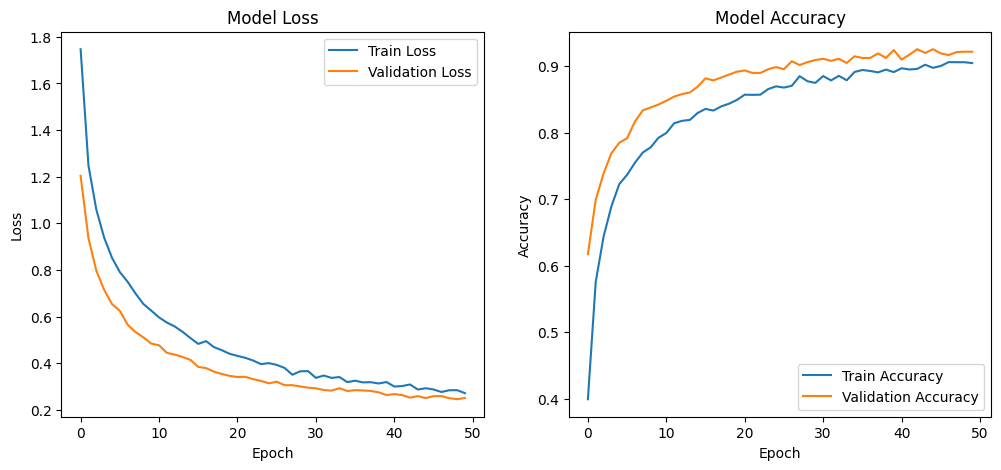

In [172]:
def plot_training_history(history_dictionary):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_dictionary['loss'], label='Train Loss')
    plt.plot(history_dictionary['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.plot(history_dictionary['accuracy'], label='Train Accuracy')
    plt.plot(history_dictionary['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.show()

plot_training_history(history_dictionary)

#### Confusion Matrix

In [173]:
def plot_confusion_matrix(y_true, y_pred, label_encoder):
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_true, axis=1)

    cm = confusion_matrix(y_true_labels, y_pred_labels)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


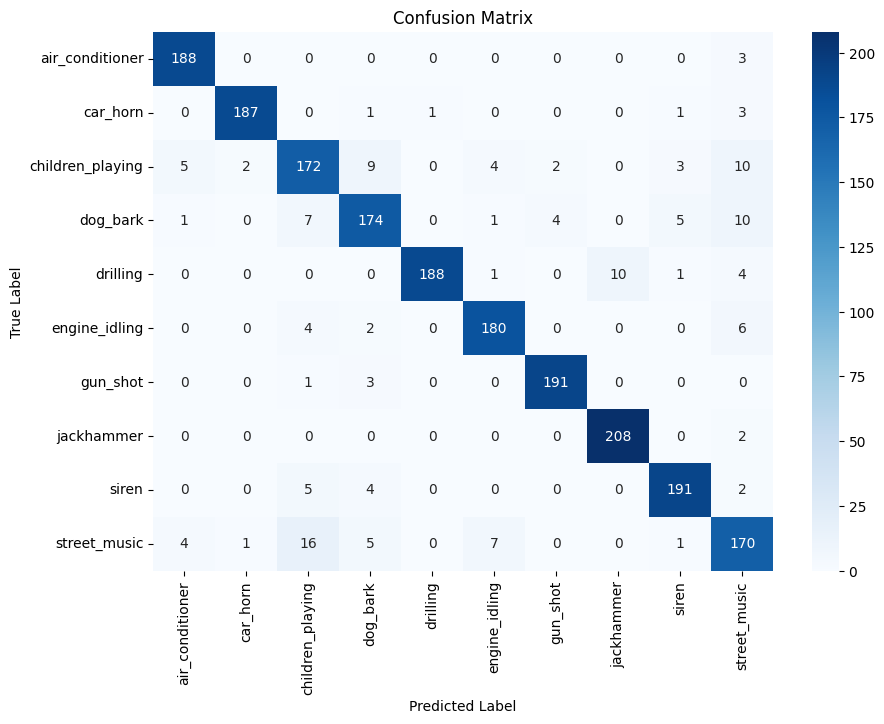

In [191]:
y_pred = load_model.predict(x_test)

y = df_audio_features['label'].values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y = to_categorical(y_encoded)

plot_confusion_matrix(y_test, y_pred, label_encoder)

## Test on Unseen Data

In [200]:
def test_on_unseen_data(model, audio_files, scaler, label_encoder):
    features = []

    for file_name in audio_files:
        data = extract_features(file_name)
        if data is not None:
            features.append(data)

    features = np.array(features)

    features = features.reshape(features.shape[0], -1)

    features = scaler.transform(features)

    predictions = model.predict(features)

    predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

    return predicted_labels

In [201]:
unseen_audio_files = [r'F:\SE\SLIIT\Y04S01\Deep Learning\Assignments\DL\Data\sm.wav']
predicted_classes = test_on_unseen_data(load_model, unseen_audio_files, scaler, label_encoder)

print("Predicted classes for unseen audio files:", predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted classes for unseen audio files: ['street_music']


F:\SE\miniconda3\envs\audio_classification\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
